### 1.1 Instal Dependencies and Setup


In [2]:
!pip install -q tensorflow opencv-python matplotlib albumentations

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import os
import time
import uuid
import cv2
import tensorflow as tf

2024-04-16 04:08:28.150052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 04:08:28.150173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 04:08:28.346350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2.1 Import TF and Deps


In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## 5.1 Run Augmentation Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
aug_data = "/kaggle/input/custom-face-det-mod/aug_data-20240414T084044Z-001/aug_data/"

### 5.2 Load Augmented Images to Tensorflow Dataset


In [14]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
train_images = tf.data.Dataset.list_files(f'{aug_data}/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [16]:
test_images = tf.data.Dataset.list_files(f'{aug_data}/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [17]:
len(os.listdir(f"{aug_data}/val/images"))

540

In [18]:
val_images = tf.data.Dataset.list_files(f'{aug_data}/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [19]:
train_images.as_numpy_iterator().next()

array([[[0.22892156, 0.25343138, 0.22745098],
        [0.2382353 , 0.2627451 , 0.2367647 ],
        [0.2367647 , 0.26127452, 0.23382352],
        ...,
        [0.25490198, 0.27450982, 0.2509804 ],
        [0.25116423, 0.27077207, 0.24724264],
        [0.2485294 , 0.26813725, 0.24460784]],

       [[0.2372549 , 0.25686276, 0.22941177],
        [0.24221814, 0.26182598, 0.234375  ],
        [0.23529412, 0.25490198, 0.22745098],
        ...,
        [0.2509804 , 0.27058825, 0.24705882],
        [0.25441176, 0.2740196 , 0.2504902 ],
        [0.2485294 , 0.26813725, 0.24460784]],

       [[0.24117647, 0.26078433, 0.23333333],
        [0.24307598, 0.2626838 , 0.23523284],
        [0.23921569, 0.25882354, 0.23137255],
        ...,
        [0.25441176, 0.2740196 , 0.2504902 ],
        [0.25441176, 0.2740196 , 0.2504902 ],
        [0.25459558, 0.27420342, 0.250674  ]],

       ...,

       [[0.6492034 , 0.6766544 , 0.60900736],
        [0.64705884, 0.67401963, 0.6122549 ],
        [0.6505515 , 0

## 6 Prepare labels

In [20]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset


In [21]:
train_labels = tf.data.Dataset.list_files(f'{aug_data}/train/labels/*.json', shuffle=False)
train_labels.as_numpy_iterator().next()

b'/kaggle/input/custom-face-det-mod/aug_data-20240414T084044Z-001/aug_data//train/labels/7016b916-f8c6-11ee-a831-e5bedddd6508.0.json'

In [22]:
train_labels = tf.data.Dataset.list_files(f'{aug_data}/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [23]:
test_labels = tf.data.Dataset.list_files(f'{aug_data}/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [24]:
len(os.listdir(f"{aug_data}/val/labels"))

540

In [25]:
val_labels = tf.data.Dataset.list_files(f'{aug_data}/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3662 , 0.11224, 0.8057 , 0.5513 ], dtype=float16))

## 7. Combine Label and Image Samples


### 7.1 Check Partition Lengths


In [26]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2520, 2520, 480, 480, 540, 540)

### 7.2 Create Final Datasets (Images/Labels)


In [27]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [28]:
train.as_numpy_iterator().next()[0]   # contains 8 data points

array([[[[0.14901961, 0.15294118, 0.13333334],
         [0.14852941, 0.15245098, 0.13284314],
         [0.14491421, 0.14883578, 0.12922794],
         ...,
         [0.14117648, 0.14117648, 0.14117648],
         [0.14117648, 0.14117648, 0.14117648],
         [0.14454657, 0.14454657, 0.14454657]],

        [[0.14656863, 0.1504902 , 0.13039216],
         [0.14852941, 0.15245098, 0.13284314],
         [0.14460784, 0.14803922, 0.12990196],
         ...,
         [0.14901961, 0.14901961, 0.14901961],
         [0.15245098, 0.15245098, 0.15245098],
         [0.14264706, 0.14264706, 0.14264706]],

        [[0.14656863, 0.1504902 , 0.12843138],
         [0.14895834, 0.1523897 , 0.13425244],
         [0.14160539, 0.14160539, 0.13376226],
         ...,
         [0.14901961, 0.14901961, 0.14901961],
         [0.14908089, 0.14908089, 0.14908089],
         [0.14246324, 0.14246324, 0.14246324]],

        ...,

        [[0.54381126, 0.54920346, 0.5134191 ],
         [0.5441789 , 0.55202204, 0.5088848 ]

In [29]:
train.as_numpy_iterator().next()[1]   # 8 labels

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2922 , 0.0636 , 0.769  , 0.597  ],
        [0.2795 , 0.4907 , 0.6606 , 0.939  ],
        [0.0704 , 0.09235, 0.5327 , 0.568  ],
        [0.3333 , 0.0674 , 0.757  , 0.5957 ],
        [0.3044 , 0.1074 , 0.7373 , 0.547  ],
        [0.3413 , 0.3909 , 0.791  , 0.856  ],
        [0.2593 , 0.2122 , 0.5757 , 0.6074 ],
        [0.384  , 0.0178 , 0.8735 , 0.6265 ]], dtype=float16))

In [30]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [31]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### 7.3 View Images and Annotations


In [32]:
data_samples = train.as_numpy_iterator()

In [33]:
res = data_samples.next()

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


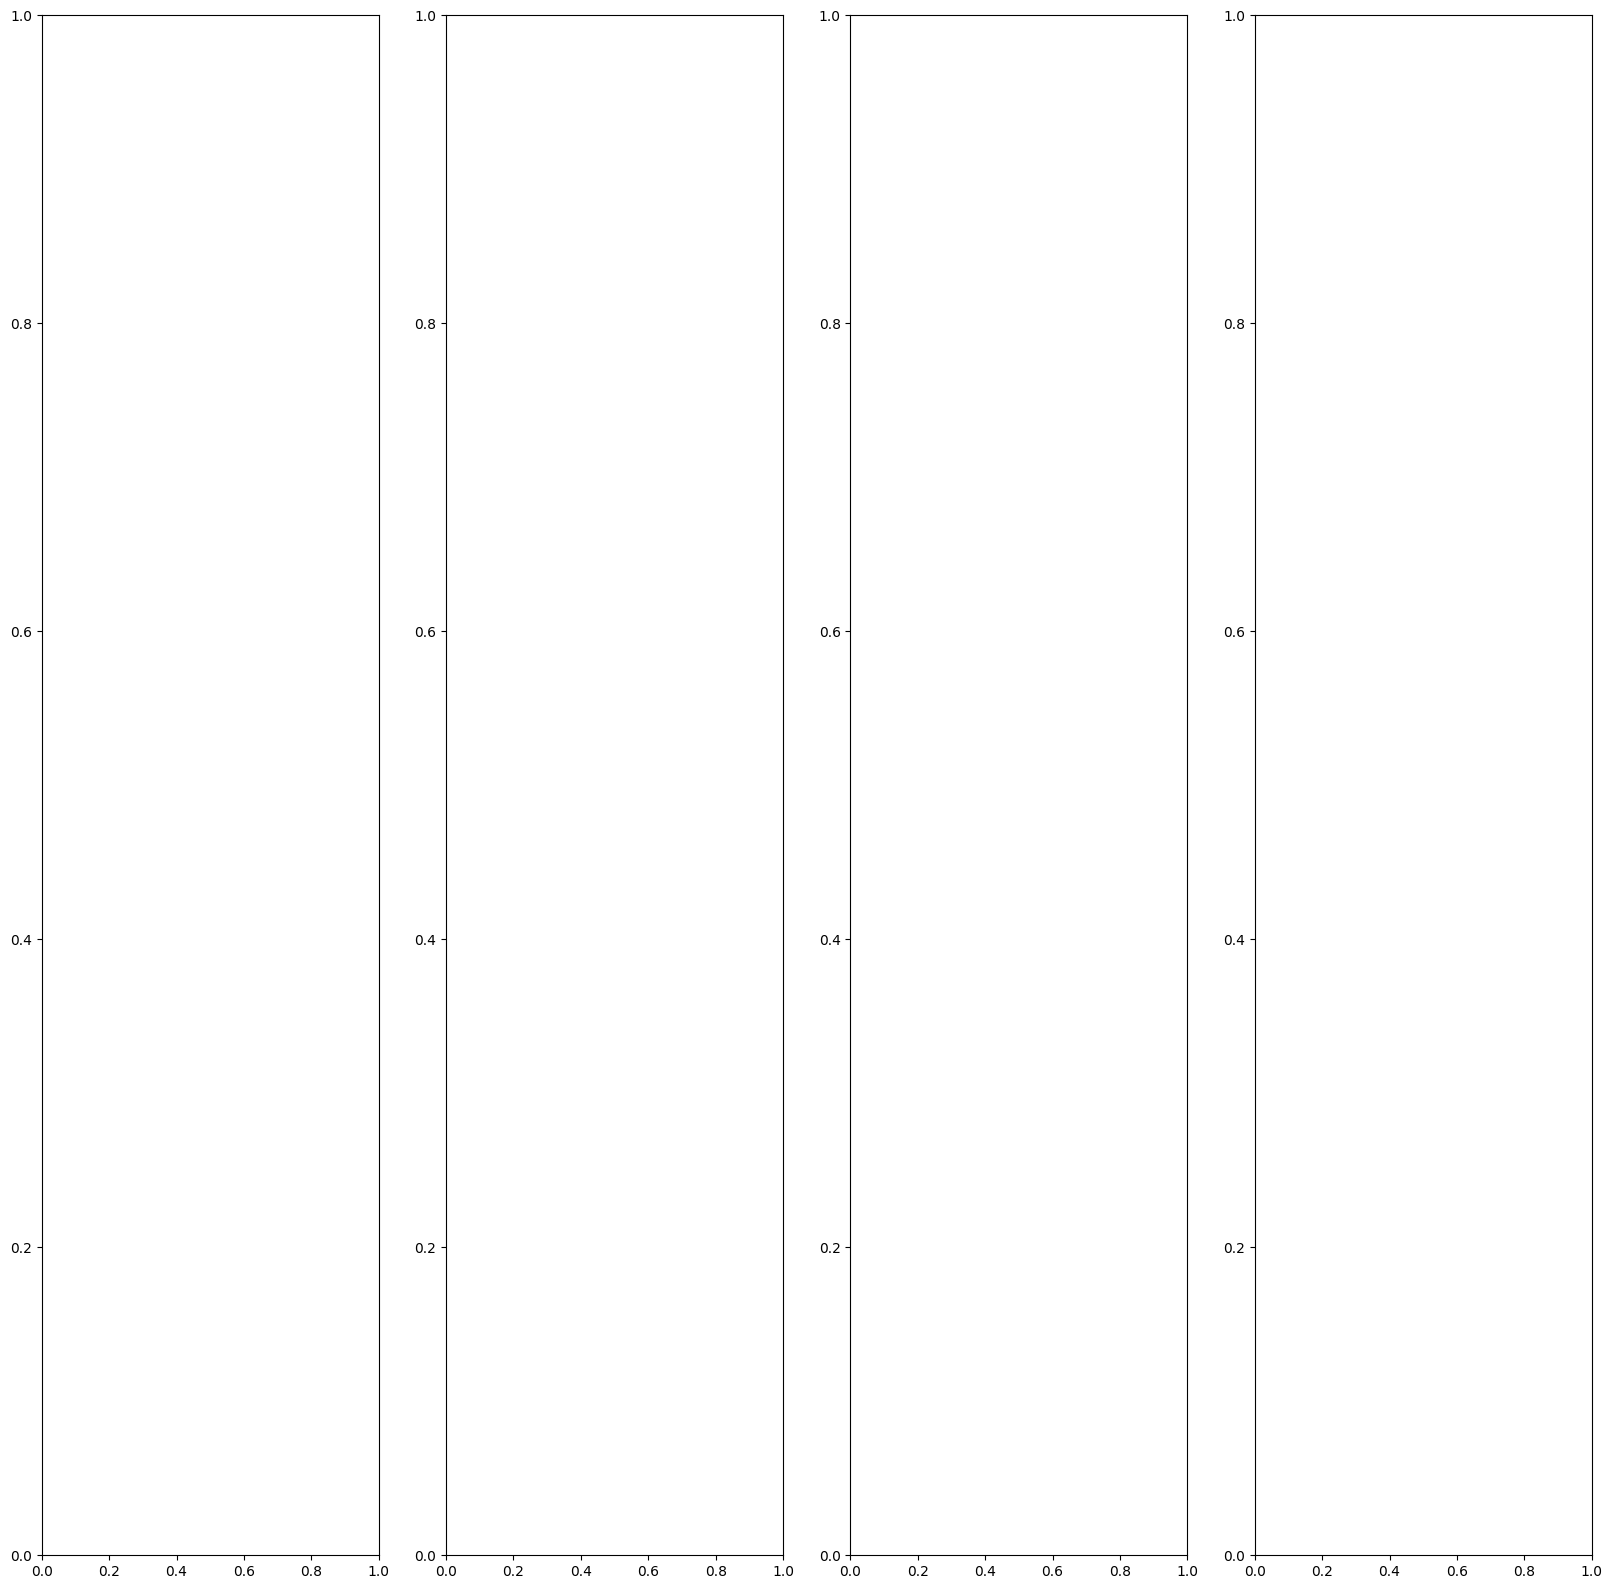

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## 8. Build Deep Learning using the Functional API


### 8.1 Import Layers and Base Network

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [38]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [39]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [40]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [41]:
facetracker = build_model()

In [42]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [43]:
X, y = train.as_numpy_iterator().next()

In [44]:
X.shape

(8, 120, 120, 3)

In [45]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2983 , 0.446  , 0.7275 , 0.9424 ],
        [0.325  , 0.409  , 0.758  , 0.848  ],
        [0.4316 , 0.10986, 0.886  , 0.5854 ],
        [0.206  , 0.3728 , 0.644  , 0.802  ],
        [0.2202 , 0.4065 , 0.67   , 0.8716 ],
        [0.4326 , 0.0586 , 0.9106 , 0.5483 ],
        [0.442  , 0.06775, 0.881  , 0.507  ],
        [0.198  , 0.1165 , 0.653  , 0.592  ]], dtype=float16))

In [46]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [47]:
classes, coords

(array([[0.4145522 ],
        [0.44561577],
        [0.47522232],
        [0.4284244 ],
        [0.43263113],
        [0.48175672],
        [0.46004346],
        [0.43947697]], dtype=float32),
 array([[0.4469479 , 0.5721664 , 0.43258595, 0.45389274],
        [0.47005725, 0.53916496, 0.46131027, 0.43496853],
        [0.49068606, 0.605395  , 0.469076  , 0.5335181 ],
        [0.4738306 , 0.5166055 , 0.4664718 , 0.46665442],
        [0.4598345 , 0.5382648 , 0.46360156, 0.46107513],
        [0.4544467 , 0.5546372 , 0.47708496, 0.47755647],
        [0.4882333 , 0.6133271 , 0.4788987 , 0.47628826],
        [0.49083593, 0.5784342 , 0.4766691 , 0.50071514]], dtype=float32))

## 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [48]:
batches_per_epoch = len(train)
# lr_decay = (1./0.75 -1)/batches_per_epoch

In [49]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

### 9.2 Create Localization Loss and Classification Loss

In [50]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [51]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [52]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4368277>

In [53]:
classloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7293056>

## 10. Train Neural Network

### 10.1 Create Custom Model Class

In [54]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [55]:
model = FaceTracker(facetracker)

In [56]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [57]:
logdir='logs'

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:
%%time
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


I0000 00:00:1713240733.880254      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 [==============================] - 42s 79ms/step - total_loss: 0.1945 - class_loss: 0.0103 - regress_loss: 0.1894 - val_total_loss: 0.0797 - val_class_loss: 2.2561e-05 - val_regress_loss: 0.0797
Epoch 2/40
315/315 [==============================] - 31s 70ms/step - total_loss: 0.0488 - class_loss: 1.1197e-05 - regress_loss: 0.0488 - val_total_loss: 0.0721 - val_class_loss: 2.3842e-07 - val_regress_loss: 0.0721
Epoch 3/40
315/315 [==============================] - 30s 69ms/step - total_loss: 0.0302 - class_loss: 2.8851e-06 - regress_loss: 0.0302 - val_total_loss: 0.0994 - val_class_loss: 1.0431e-06 - val_regress_loss: 0.0994
Epoch 4/40
315/315 [==============================] - 31s 68ms/step - total_loss: 0.0220 - class_loss: 1.3913e-06 - regress_loss: 0.0220 - val_total_loss: 0.0352 - val_class_loss: 2.9802e-08 - val_regress_loss: 0.0352
Epoch 5/40
315/315 [==============================] - 28s 68ms/step - total_loss: 0.0180 - class_loss: 8.7078e-07 - regress_loss: 0.0180 - val_

In [60]:
hist.history

{'total_loss': [0.04485291987657547,
  0.025560377165675163,
  0.012432670220732689,
  0.016747089102864265,
  0.03233123943209648,
  0.0080406554043293,
  0.012443235144019127,
  0.012310294434428215,
  0.00752122001722455,
  0.006853342056274414,
  0.010149732232093811,
  0.024260712787508965,
  0.016406729817390442,
  0.004391605965793133,
  0.004054959863424301,
  0.012392275035381317,
  0.013243414461612701,
  0.00565420463681221,
  0.010968271642923355,
  0.08026036620140076,
  0.004048773553222418,
  0.0026103428099304438,
  0.004774149041622877,
  0.0027614827267825603,
  0.0018243767553940415,
  0.002389731351286173,
  0.0018584155477583408,
  0.0026414883323013783,
  0.0022268788889050484,
  0.00809164997190237,
  0.0035181709099560976,
  0.002015674253925681,
  0.0029382873326539993,
  0.003161438275128603,
  0.0026780846528708935,
  0.00184327969327569,
  0.0012579425238072872,
  0.004074893891811371,
  0.024688655510544777,
  0.0015773996710777283],
 'class_loss': [1.91632

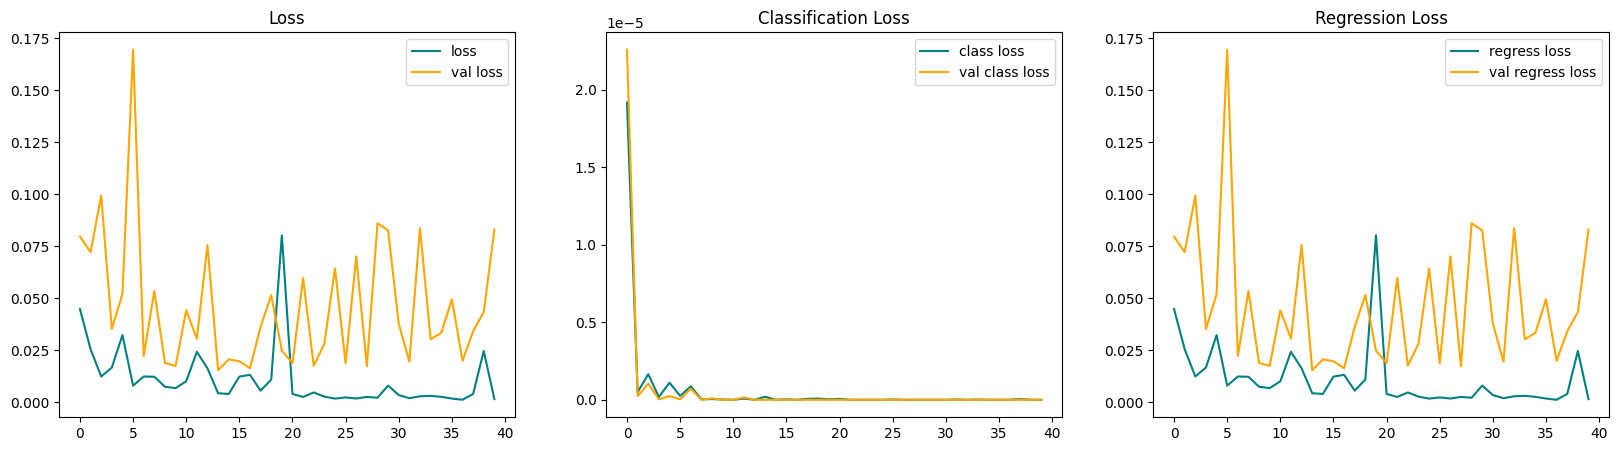

In [61]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [62]:
test_data = test.as_numpy_iterator()

In [63]:
test_sample = test_data.next()
test_sample[0]

array([[[[0.6754289 , 0.60876226, 0.64797795],
         [0.6759804 , 0.6093137 , 0.6485294 ],
         [0.6786152 , 0.61194855, 0.6433211 ],
         ...,
         [0.55833334, 0.4995098 , 0.47205883],
         [0.5661765 , 0.4995098 , 0.47077206],
         [0.5589461 , 0.48921567, 0.46029413]],

        [[0.6771446 , 0.6104779 , 0.644424  ],
         [0.6788603 , 0.61219364, 0.64957106],
         [0.6788603 , 0.61219364, 0.6435662 ],
         ...,
         [0.5559436 , 0.50104165, 0.46574754],
         [0.5564338 , 0.50153184, 0.46525735],
         [0.5545956 , 0.49325982, 0.4548407 ]],

        [[0.6745098 , 0.60784316, 0.6392157 ],
         [0.67101717, 0.6043505 , 0.6425858 ],
         [0.6745098 , 0.60784316, 0.6392157 ],
         ...,
         [0.5555147 , 0.50061274, 0.45747548],
         [0.5490809 , 0.49417892, 0.4441789 ],
         [0.5550858 , 0.5001838 , 0.4541054 ]],

        ...,

        [[0.1622549 , 0.09950981, 0.14264706],
         [0.16862746, 0.10588235, 0.14901961]

### 10.3 prediction

In [65]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 23ms/step


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


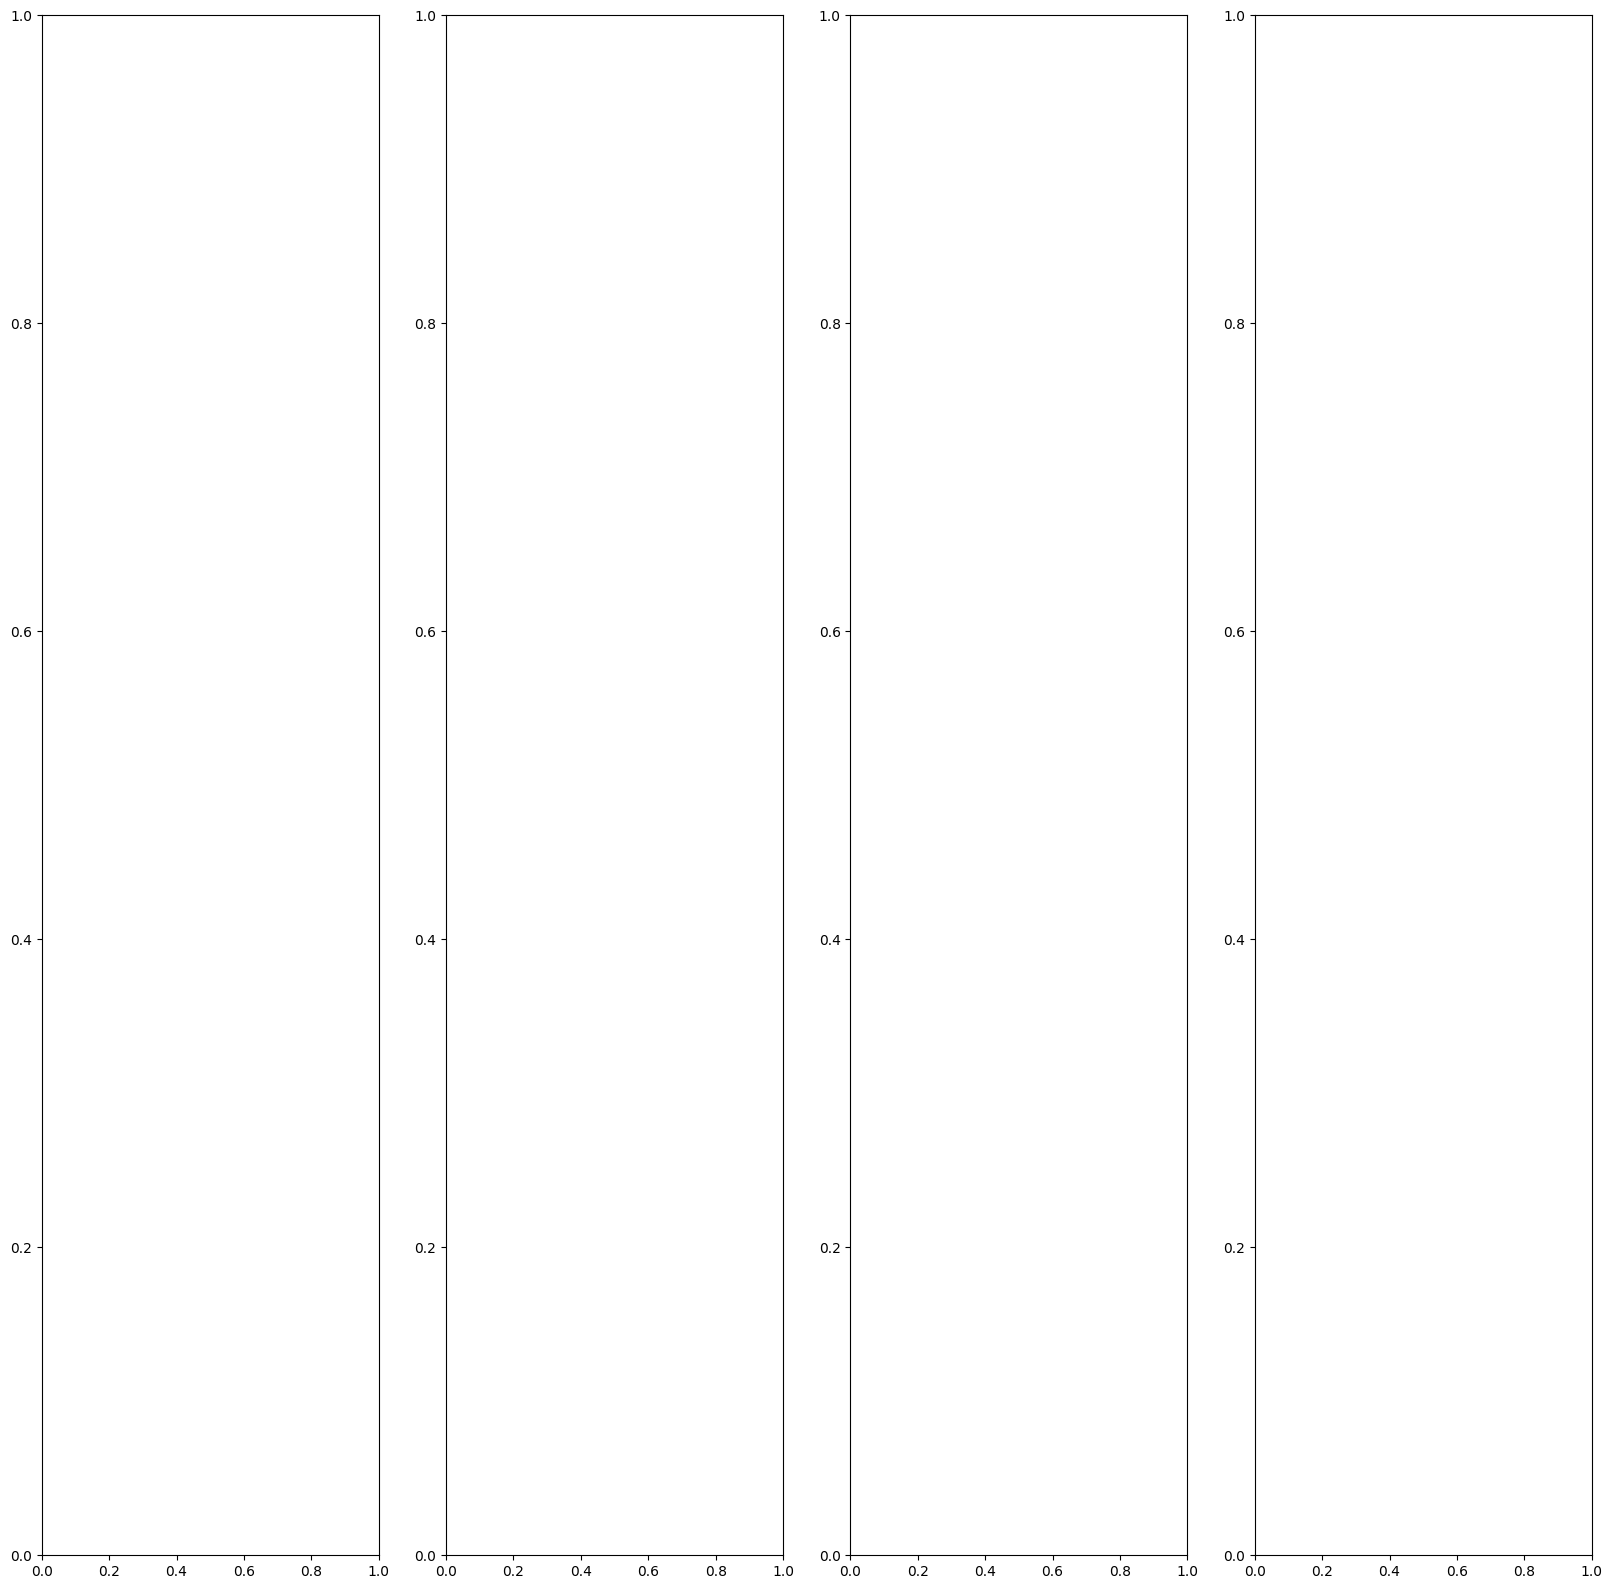

In [66]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [67]:
from tensorflow.keras.models import load_model

In [ ]:
# model_path ="/content/drive/MyDrive/deep_learning_projects/FaceDetection/model/"

In [68]:
facetracker.save('40_facetracker.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
facetracker = load_model('40_facetracker.h5')

### 10.4 custom image  detection

In [ ]:
..

In [ ]:
test_image = "/content/test_image.jpg"
test_image = load_image(test_image)
test_image = tf.image.resize(test_image, (120,120))
test_image = test_image/255

In [ ]:
test_image.shape

In [ ]:
test_sample[0][0].shape

In [ ]:
# shape = tf.TensorShape([120, 120, 3])
tuple_shape = tuple(test_image.shape.as_list())

print(tuple_shape)

In [ ]:
facetracker.predict(test_image)

In [ ]:
import tensorflow as tf

# Assuming test_image is your tensor with shape TensorShape([120, 120, 3])
test_image = tf.random.normal([120, 120, 3])

# Reshape test_image into a vector of size 3
vector_image = tf.reshape(test_image, [-1, 3])

print(vector_image.shape)  # Output should be TensorShape([14400, 3])